In [1]:
import torch
from Model.complete_model import CVSeaNet
import matplotlib.pyplot as plt
import rasterio

Backbone(
  (ConvNet): Sequential(
    (0): Sequential(
      (0): ComplexConv2d(
        (convLayer_real): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (convLayer_imag): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), bias=False)
      )
      (1): ComplexReLU6(
        (relu_real): ReLU6(inplace=True)
        (relu_imag): ReLU6(inplace=True)
      )
    )
    (1): ComplexMBConvBlock(
      (block): Sequential(
        (0): ComplexConv2d(
          (convLayer_real): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (convLayer_imag): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): ComplexReLU6(
          (relu_real): ReLU6(inplace=True)
          (relu_imag): ReLU6(inplace=True)
        )
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ComplexDwConv2d(
          (real_conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups

c:\Users\genna\.conda\envs\TorchEnv\Lib\site-packages\rasterio\__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


tensor([[[[32., 22., 26.,  ..., 20., 20., 13.],
          [21., 13., 19.,  ..., 20., 23., 19.],
          [23., 19., 24.,  ..., 23., 26., 22.],
          ...,
          [31., 24., 18.,  ..., 32., 24., 30.],
          [23., 32., 29.,  ..., 27., 23., 19.],
          [25., 29., 26.,  ..., 25., 25., 23.]],

         [[32., 22., 26.,  ..., 20., 20., 13.],
          [21., 13., 19.,  ..., 20., 23., 19.],
          [23., 19., 24.,  ..., 23., 26., 22.],
          ...,
          [31., 24., 18.,  ..., 32., 24., 30.],
          [23., 32., 29.,  ..., 27., 23., 19.],
          [25., 29., 26.,  ..., 25., 25., 23.]]]], device='cuda:0',
       dtype=torch.float16) torch.Size([1, 2, 866, 1177])


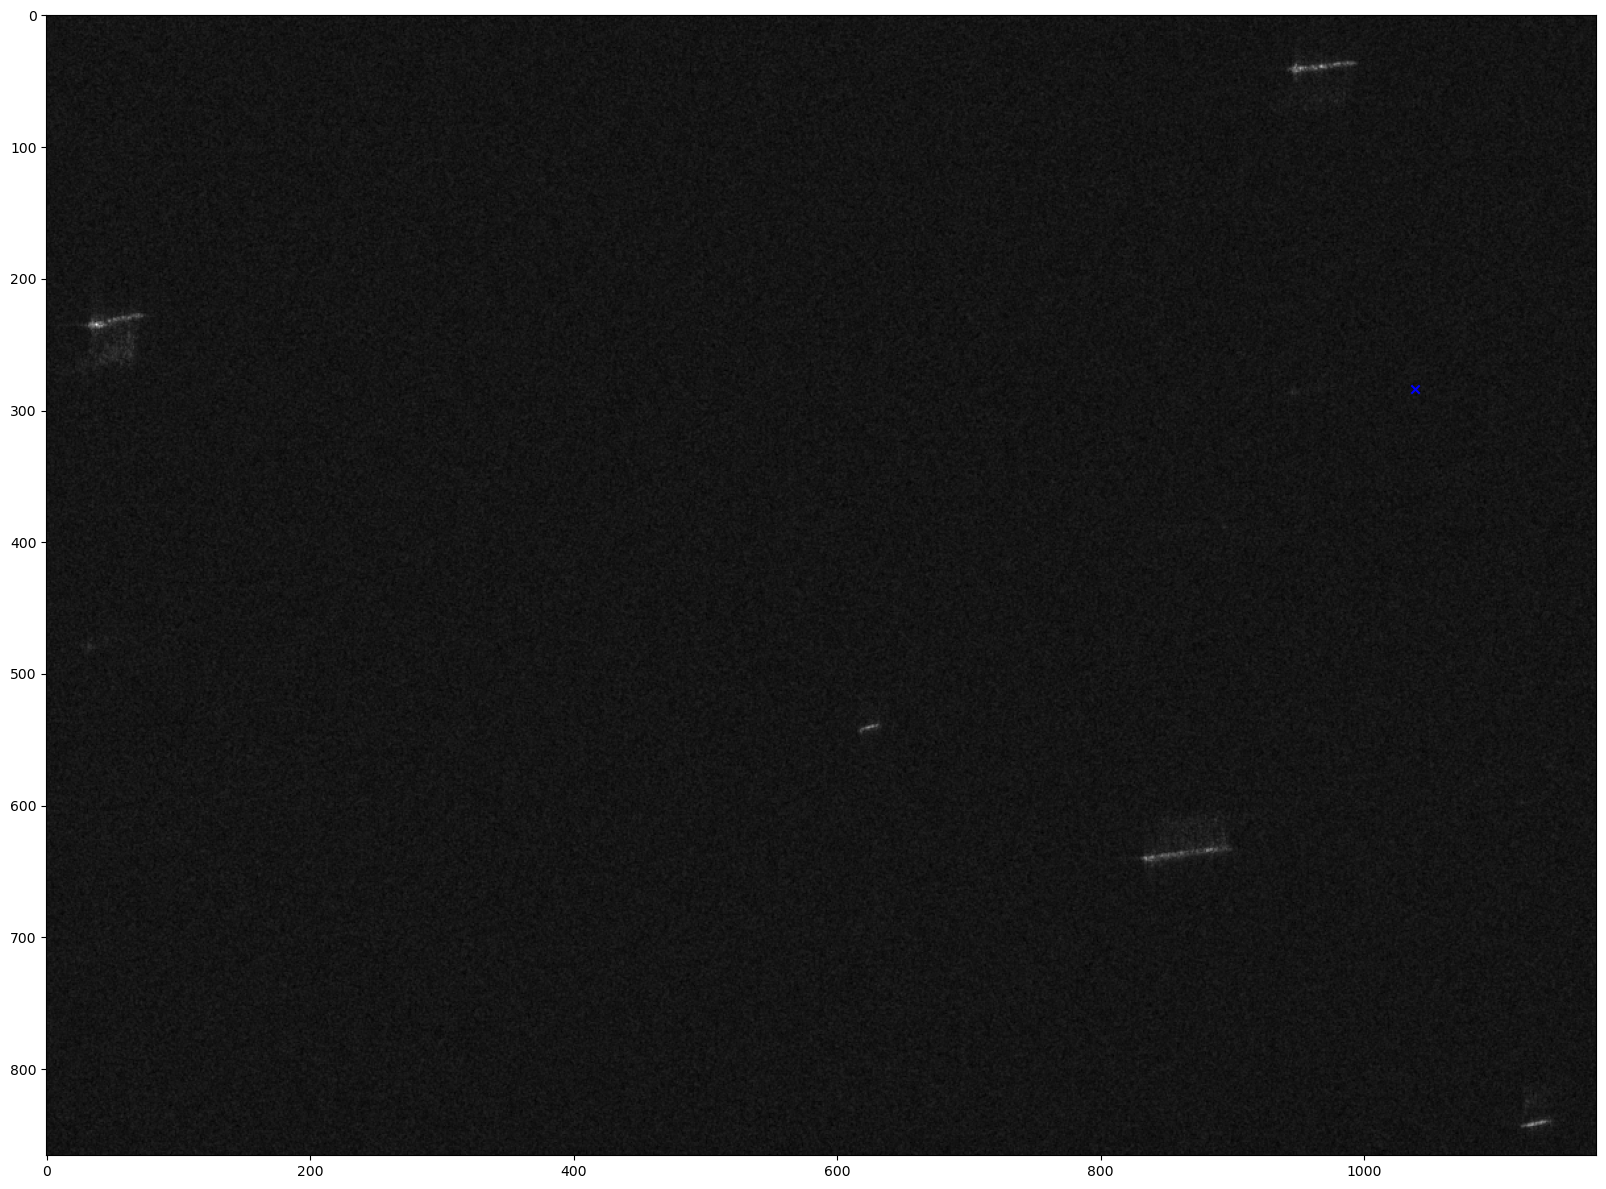

In [3]:
path_state = r"Weights\epoch=64-step=134160.ckpt"
state = torch.load(path_state)
in_channels = in_channels = state['hyper_parameters']['in_channels']
in_res = state['hyper_parameters']['in_res']
backbone_type_id = state['hyper_parameters']['backbone_type_id']
backbone_architecture = state['hyper_parameters']['backbone_architecture']
score_threshold = state['hyper_parameters']['score_threshold']
real_conv_block = state['hyper_parameters']['real_conv_block']
model = CVSeaNet(in_channels=in_channels, in_resolution=in_res, backbone_params=[backbone_type_id, backbone_architecture],
                 score_threshold=score_threshold, real_conv_block=real_conv_block).to(device='cuda', dtype=torch.float16)
state_dict_without_prefix = {key.replace('model.', ''): value for key, value in state['state_dict'].items()}     
model.load_state_dict(state_dict_without_prefix)

file_path = input("Insert image path (.tif)")
with rasterio.open(file_path) as f:
    x_real_vh = f.read(1)
    x_imag_vh = f.read(2)
x_real_vh = torch.from_numpy(x_real_vh)
x_imag_vh = torch.from_numpy(x_imag_vh)
img = torch.stack((x_real_vh, x_imag_vh))
img = img.unsqueeze(0).to(device='cuda', dtype=torch.float16)


model.eval()
out = model(img)
idx_kp = torch.nonzero(out['Keypoints heatmap'] > score_threshold)
idx_kp = idx_kp[:, 2:]
off = out['Offset heatmap']
x_off = off[0,0,idx_kp[:,0], idx_kp[:,1]].unsqueeze(-1)
y_off = off[0,1,idx_kp[:,0], idx_kp[:,1]].unsqueeze(-1)
off = torch.cat((x_off, y_off),dim=-1)
scaled_out = idx_kp + off
scaled_out = scaled_out * out['Scale Parameter']
plt.figure(figsize=(20,20))
plt.imshow((torch.abs(img[0,0].to(torch.float) + 1j * img[0,1].to(torch.float)).cpu().numpy()), cmap='gray')
plt.scatter(scaled_out[:,0].to(torch.float).detach().cpu().numpy(), scaled_out[:,1].to(torch.float).detach().cpu().numpy(), marker='x', c='blue')